# Creating a Correlation Graph for A and B Channel Data

Purpose is to create a 4 by 4 grid of correlation plots of each sensor

- X is B PM2.5_atm, Y is A Pm2.5_atm
- 24 hour average
- Mark outliers red that 1) exceed absolute difference 5 ug/m3 and/or 2) exceed 16% error with channel A baseline

https://cfpub.epa.gov/si/si_public_record_Report.cfm?Lab=CEMM&dirEntryId=348236

### Setup

First import required packages.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


Then import the data.

In [127]:
data_A = pd.read_parquet('../data/interim/PurpleAir MASTER realtime individual.parquet')[['PM2.5_ATM_ug/m3']]
print('Primary_A imported')
data_B = pd.read_parquet('../data/interim/PurpleAir B MASTER realtime individual.parquet')[['PM2.5_ATM_ug/m3']]
print('Primary_B imported')

Primary_A imported
Primary_B imported


In [128]:
# https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex
data_A = data_A.groupby([pd.Grouper(level='sensor_name'),pd.Grouper(level='created_at', freq='D')]).mean()\
    .rename(columns={'PM2.5_ATM_ug/m3':'Channel A PM2.5 (ug/m3)'})
data_B = data_B.groupby([pd.Grouper(level='sensor_name'),pd.Grouper(level='created_at', freq='D')]).mean()\
    .rename(columns={'PM2.5_ATM_ug/m3':'Channel B PM2.5 (ug/m3)'})

In [129]:
data_B = data_B.reset_index()
new_names = data_B['sensor_name'].apply(lambda x: x.replace(' B',''))
data_B['sensor_name'] = new_names
data_B = data_B.set_index(['sensor_name','created_at'])


In [139]:
data = pd.concat([data_A, data_B], axis=1,join='inner')
data['diff'] =  abs(data['Channel A PM2.5 (ug/m3)']-data['Channel B PM2.5 (ug/m3)'])
data['percent_error'] = data['diff']*100/data['Channel A PM2.5 (ug/m3)']
data['outlier'] = (data['diff'] > 5) & (data['percent_error'] > 16)
bound = 40
data = data.loc[(data['Channel A PM2.5 (ug/m3)']<bound) &(data['Channel B PM2.5 (ug/m3)']<bound)]

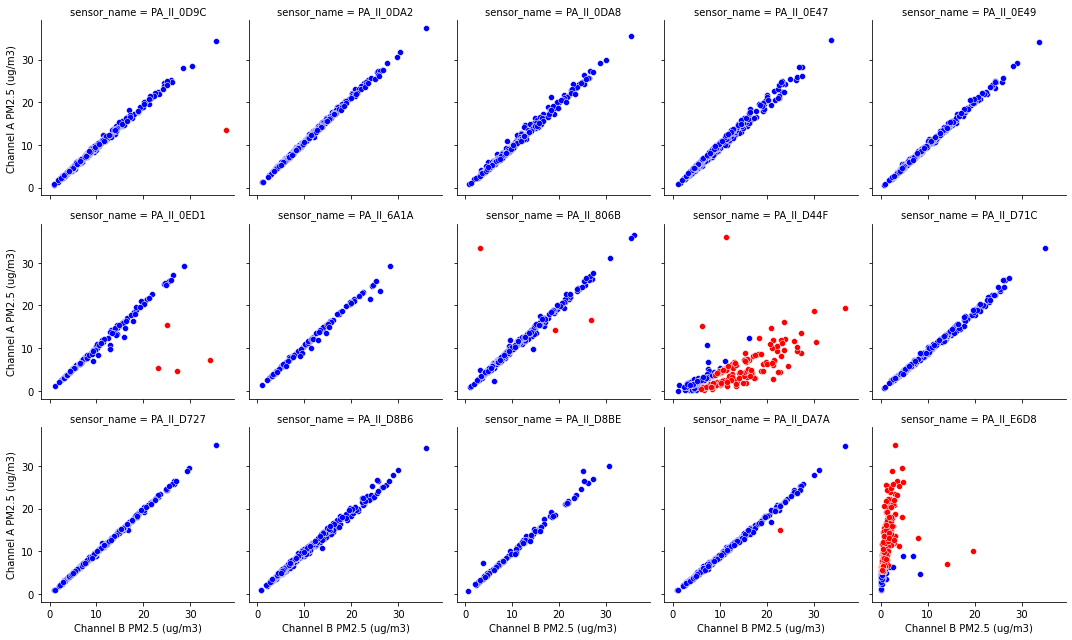

In [140]:
#https://seaborn.pydata.org/tutorial/axis_grids.html
g = sns.FacetGrid(data.reset_index().set_index('created_at'), col="sensor_name", hue='outlier', palette=['blue','red'], col_wrap=5)
g.map(sns.scatterplot,'Channel B PM2.5 (ug/m3)','Channel A PM2.5 (ug/m3)')